### Considered model: four-bar linkage (= two link manipulator + one link manipulator + rigid coupling)


This Notebook depends on symbtools >=0.2.5

→ `pip install --upgrade symbtools`





In [1]:
%load_ext ipydex.displaytools
%matplotlib inline

import sys
# to load assimulo under wsl2
sys.path.append('/home/kwrede/miniconda3/lib/python3.8/site-packages')
sys.path.append('/home/wredi/miniconda3/lib/python3.8/site-packages')

import os
import pickle
import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing

# using wredsen's symbtools fork (https://github.com/wredsen/symbtools @ DAE_statefeedback), assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)

import scipy.integrate as sc_integrate
from scipy.optimize import fmin
import matplotlib.pyplot as pl
from assimulo.solvers import ODASSL as SOLVER # Imports the solver ODASSL from Assimulo
from assimulo.problem import Overdetermined_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

Could not find No module named 'assimulo.solvers.sundials'
Could not find No module named 'assimulo.solvers.kinsol'
/home/wredi/.local/lib/python3.8/site-packages/assimulo/solvers/odepack.py:701: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  N.array([[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],  # 5th order
Could not find GLIMDA.


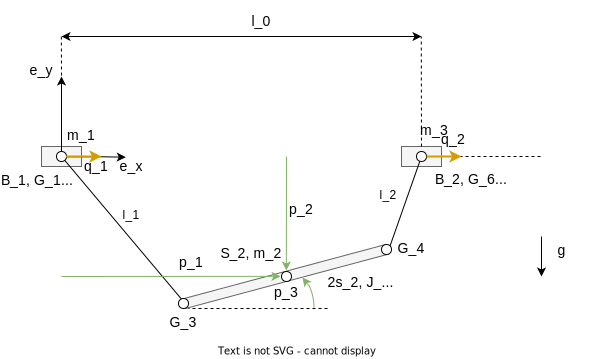

In [2]:
from IPython.display import Image
from IPython.core.display import SVG
SVG(filename='ODE_flatness_analysis_simulation_diagram.svg')

In [46]:
t = sp.Symbol('t')  # time variable

# coordinates
np = 2 # number of passive coordinates (not directly actuated) -> x_load, y_load
nq = 1 # number of actuated coordinates -> x_1
n = np + nq

pp = st.symb_vector("p1:{0}".format(np+1)) # vector of passive coordinates
qq = st.symb_vector("q1:{0}".format(nq+1)) # vector of actuated coordinates



# vector of control inputs
aa = st.symb_vector("a1:{0}".format(2+1)) ##:T
# vector of all coordinates
ttheta = st.row_stack(pp, qq) ##:T
# vector of velocities 
tthetad = st.time_deriv(ttheta, ttheta) ##:T
# vector of accelerations
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
tthetaddd = st.time_deriv(ttheta, ttheta, order=3) ##:T
tthetadddd = st.time_deriv(ttheta, ttheta, order=4) ##:T

st.make_global(ttheta, tthetad, tthetadd, tthetaddd, tthetadddd)

QQ = st.symb_vector("Q1:{0}".format(n+1)) ##:T # vector of generalized foces
st.make_global(QQ)

---

---

---

---

---

---

---

In [47]:
# symbols for analytic equations
params = sp.symbols('m1, m2, l1, g')
st.make_global(params)

# symbols for control inputs
# ttau = sp.symbols('tau')
tau1, tau2 = ttau = st.symb_vector("tau1, tau2")


Specify the geometry (joints G and centers of masses S)

---

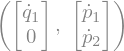

---

In [48]:
# unit vectors
ex = sp.Matrix([1, 0])
ey = sp.Matrix([0, 1])

# basis 1 and 2 (cart positions)
S1 = G1 = B1 = sp.Matrix([q1, 0]) ##:

# center of gravity of load
S2 = sp.Matrix([p1, p2])

# Time derivatives of centers of masses
Sd1, Sd2 = st.col_split(st.time_deriv(st.col_stack(S1, S2), ttheta)) ##:

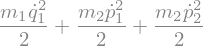

---

---

In [49]:
# kinetic energy
T1 = (m1/2 * Sd1.T*Sd1)[0] 
T2 = (m2/2 * Sd2.T*Sd2)[0]

T = T1 + T2 ##:

# potential energy
V = m2*g*S2[1] ##:

this model is very easy ...

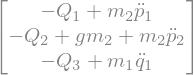

In [50]:
mod = mt.generate_symbolic_model(T, V, ttheta, QQ)
mod.eqns

... but $Q_i$ are yet unknown → calculate them via the principle of virtual work, see e.g. [Wikipedia](https://en.wikipedia.org/wiki/Generalized_forces#Virtual_work):
$$
\delta W = \sum_{i=1}^n \mathbf {F}_{i} \cdot \frac {\partial \mathbf {r}_i} {\partial q_1} \delta q_1 +\ldots + \sum_{i=1}^n \mathbf {F}_{i} \cdot \frac {\partial \mathbf {r}_i} {\partial q_m} \delta q_m.
$$

- $ \mathbf {F}_{i}$ applied forces, i.e.  $i=1,2$ → cart-forces, $i=3,4$ → rope-foces
- $ \mathbf {r}_{i}$ position vectors of each particle (along the direction of forces): $i=1,3$ → cart, $i=2$ → load
- $ \mathbf {\delta r}_{i}$ virtual displacement
- $ \mathbf \delta q_{j} = \delta \theta_{j}$ virtual displacement of generalized coordinates


The virtual work of a system of particles can be written in the form

$$
    \delta W = Q_1\delta q_1 + \ldots + Q_m\delta q_m,
$$
where

$$
    Q_j = \sum_{i=1}^n \frac {\partial \mathbf {r}_i} {\partial q_j} \cdot \mathbf {F}_{i}  ,\quad j=1,\ldots, m, 
$$

---

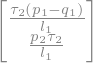

---

In [51]:
F1 = sp.Matrix([tau1, 0])  ##:T

# unit vectors for ropes to split forces according to angles
rope = (S2 - S1)

uv_rope = rope/sp.sqrt((rope.T*rope)[0])

# simplify expressions by using l1, l2 as shortcuts 
uv_rope = rope/l1

F2 = uv_rope * tau2 ##:

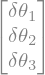

---

In [52]:
dt1, dt2, dt3 = ddelta_theta = st.symb_vector(f"\\delta\\theta_1:{n+1}") ##:

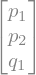

In [53]:
ttheta

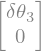

---

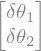

---

In [54]:
delta_S1 = S1*0
delta_S2 = S2*0

for theta, delta_theta in zip(ttheta, ddelta_theta):
    
    delta_S1 += S1.diff(theta)*delta_theta
    delta_S2 += S2.diff(theta)*delta_theta
    
delta_S1 ##:
delta_S2 ##:

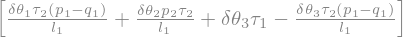

---

In [55]:
# simple part (cart)
delta_W = delta_S1.T*F1

# rope (F2 > 0 means rope is pushing from S1 towards S2)
delta_W = delta_W + delta_S2.T*F2 - delta_S1.T*F2 ##:

# convert from 1x1 Matrix to scalar:
# delta_W = delta_W[0, 0] ##:

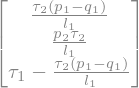

---

In [56]:
QQ_expr = delta_W.jacobian(ddelta_theta).T ##:

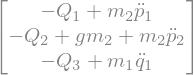

In [57]:
mod.eqns

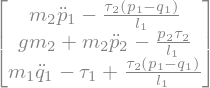

---

In [58]:
eqns = mod.eqns.subz(QQ, QQ_expr) ##:

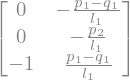

In [59]:
eqns.jacobian(ttau)

In [32]:
# eliminate the 3rd equation and tau1 → 2 remaining equations

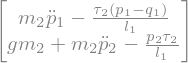

---

In [60]:
eqns1 = eqns[:-1, :] ##:

In [61]:
ttau1 = ttau[1:, :] ##:

---

TODO: one equation can be used to eleminate $\tau_2$, the remaining last equation to eleminate one other system quantity ($q_1$!)

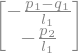

---

In [63]:
B1 = eqns1.jacobian(ttau1) ##:

So the last equation can be used to eliminate and later parametrize the input $\tau_2$:

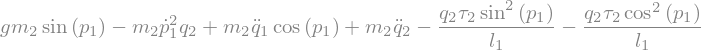

In [42]:
eqns1[-1]

The first remaining equation is used to eliminate remaining system quantities and find a flat output $\mathbf{y}$:

In [43]:
eqns1[0]

In [45]:
eqns1[0].s # --> q1 can be parametrized, using a new coordinate $\tilde{q}_1 = \ddot{q}_1$

We need its left pseudoinverse, i.e. the $2 \times 3$ matrix $B_1^{L+}$ with $B_1^{L+} B_1 = I_2$ and its left Orthocomplement $B_1^{L\perp}$ ($1 \times 3$) with $B_1^{L\perp} B_1 = 0_{1 \times 2}$

Note: both matrices are not unique: There are infinitely many Pseudoinverses and Othocomplements.

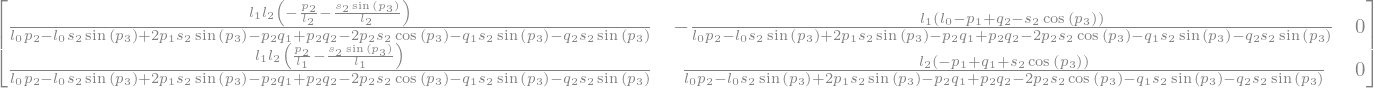

---

---

In [21]:
B1pinv = B1[:2, :].inverse_ADJ() # this is 2 x 2
B1pinv = st.col_stack(B1pinv, sp.Matrix([0, 0])) ##:

B1pinv.shape ##:

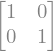

---

In [22]:
# check
tmp = (B1pinv * B1).smplf ##:


assert tmp == sp.eye(2)

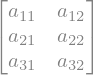

---

In [23]:
# nullspace(~kernel) (orthocomplement)
# A matrix in place represents B before substituting exact elements of B
A = st.symbMatrix(3, 2)##:

In [24]:
A_ortho = st.nullspaceMatrix(A.T).T ##:

---

In [25]:
# check

(A.T * A_ortho.T).smplf

In [26]:
# TODO: Was passiert hier genau bzw. wieso?
B1_ortho = A_ortho.subz(list(A), list(B1)).smplf*l1*l2 ##:

---

In [27]:
# check orthocomplement property:
res = (B1_ortho * B1).smplf ##:
assert not any(res)

---

Now we can assemble the $3\times 3$ transformation matrix:

$$
W_1 = 
\left(\begin{matrix}
B_1^{L+} \\
B_1^{L\perp}
\end{matrix} \right)
$$

In [28]:
W1 = st.row_stack(B1pinv, B1_ortho) ##:i

info(W1) := "<class 'sympy.matrices.dense.MutableDenseMatrix'> with count_ops: Matrix([[37, 36, 0], [36, 34, 0], [38, 33, 19]])"

---

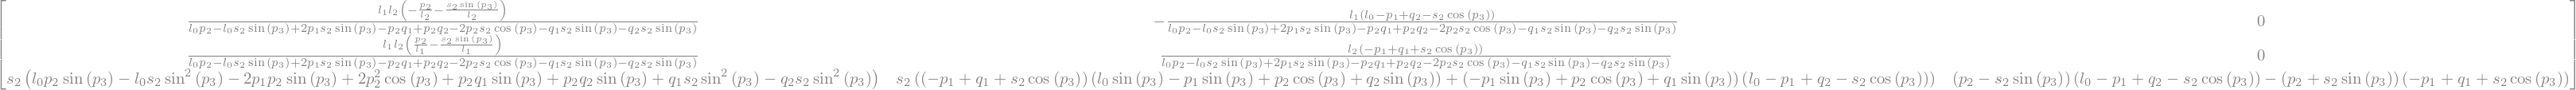

In [29]:
W1

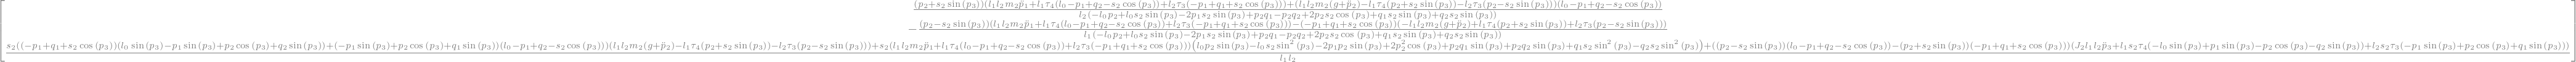

---

In [30]:
eqns2 = (W1*eqns1).smplf ##:

In [31]:
ttau1

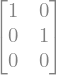

---

In [32]:
B2 = eqns2.jacobian(ttau1).smplf ##:
assert B2 == sp.eye(3)[:, :2]

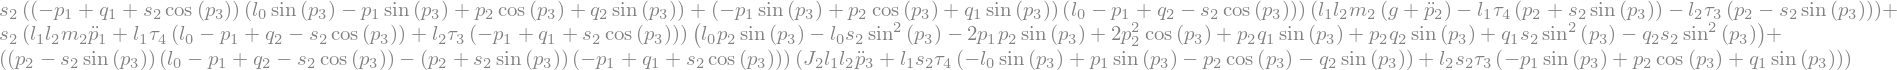

---

In [33]:
# eliminate the first two equations and tau3, tau4
eqn3 = eqns2[-1, 0] *l1*l2 ##:

In [34]:
eqn3.expand().s

In `eqn3` $q_1, q_2$ only occur algebraicly:  the structure is $0 = \kappa_0 + \kappa_{1, 0} q_1+ \kappa_{0,1} q_2 + \kappa_{1, 1} q_1 q_2$. Thus, $q_2$ (or $q_1$) can be eliminated, together with the last equation.

The remaining quantities form the flat output: $\mathbf{y} = (p_1, p_2, p_3, q_1)^T$.

All other quantities can be derived from $\mathbf y(\cdot)$: $q_2$ from `eqn3` and then the inputs from the earlier eliminated equations. Togehter the eliminated equations yield the parametrization of the system quantities by the flat output.

In [35]:
kappa_10 = eqn3.diff(q1).subs(q2, 0).smplf
kappa_01 = eqn3.diff(q2).subs(q1, 0).smplf
kappa_11 = eqn3.diff(q1).diff(q2).smplf

In [36]:
kappa_0 = (eqn3 - kappa_10*q1 - kappa_01*q2 - kappa_11*q1*q2).smplf

In [37]:
kk = sp.Matrix([kappa_0, kappa_01, kappa_10, kappa_11])

In [38]:
kk.s

# System parameterization by flat output

In [39]:
flat_q2 = sp.matrices.dense.MutableDenseMatrix(sp.solve(eqn3, q2))
flat_q2 = flat_q2.smplf
flat_q2.s ##:

---

In [40]:
# time derivative of q2 used later
flat_qddot2 = st.time_deriv(flat_q2, ttheta, order=2)
flat_qddot2.s ##:

---

In [41]:
flat_tau4 = sp.matrices.dense.MutableDenseMatrix(sp.solve(eqns2[1], tau4)) 
flat_tau4 = flat_tau4.subz([l2], [sp.sqrt((rope2.T*rope2)[0])]) # substituting l2 for variable rope length
flat_tau4 = flat_tau4.subz([q2], flat_q2)
flat_tau4.s ##:

---

In [42]:
flat_tau3 =  sp.matrices.dense.MutableDenseMatrix(sp.solve(eqns2[0], tau3)) 
flat_tau3 = flat_tau3.subz([q2], flat_q2)
flat_tau3 = flat_tau3.smplf
flat_tau3.s ##:

---

In [43]:
flat_tau3 =  sp.matrices.dense.MutableDenseMatrix(sp.solve(eqns2[0], tau3)) 
flat_tau3 = flat_tau3.subz([l1], [sp.sqrt((rope1.T*rope1)[0])]) # substituting l1 for variable rope length
flat_tau3 = flat_tau3.subz([q2], flat_q2)
flat_tau3.s ##:

---

In [44]:
flat_tau2 = sp.matrices.dense.MutableDenseMatrix(sp.solve(eqns[-1], tau2))
flat_tau2 = flat_tau2.subz([l2], [sp.sqrt((rope2.T*rope2)[0])]) # substituting l2 for variable rope length
flat_tau2 = flat_tau2.subz([q2, qddot2, tau4, tau3], [*flat_q2, *flat_qddot2, *flat_tau4, *flat_tau3])
flat_tau2.s ##:

---

In [45]:
flat_tau1 = sp.matrices.dense.MutableDenseMatrix(sp.solve(eqns[-2], tau1))
flat_tau1 = flat_tau1.subz([l1], [sp.sqrt((rope1.T*rope1)[0])]) # substituting l1 for variable rope length
flat_tau1 = flat_tau1.subz([q2, tau4, tau3], [*flat_q2, *flat_tau4, *flat_tau3])
flat_tau1.s ##:

---

In [46]:
pickle_data = [mod, eqns, ttau, flat_tau1, flat_tau2, flat_tau3, flat_tau4, flat_q2]

In [47]:
# store with pickle

with open("flatness_analysis.pcl", "wb") as pfile:
    pickle.dump(pickle_data, pfile)